# Подключение библиотеки

In [1]:
import timeit
import time
import sys
import os
import re
import numpy as np
import pandas as pd
import seaborn as sb
from tqdm.auto import tqdm
from IPython.display import display, HTML
from datetime import datetime

import matplotlib.pyplot as plt

from scipy import stats as st
# Тренды и сезонность
from statsmodels.tsa.seasonal import seasonal_decompose
# Проверка на стационарность
from statsmodels.tsa.stattools import adfuller, kpss
# Проверка на дисперсию с помощью теста Андерсона-Дарлинга
from scipy.stats import anderson

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict, TimeSeriesSplit

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder

# Многозадачная регрессия
from sklearn.multioutput import MultiOutputRegressor
# Для машинного обучения
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from catboost import CatBoostRegressor
# Метод ближайшего соседа KNN
from sklearn.neighbors import KNeighborsRegressor
# Метод опорного вектора, SVR - для регрессии
from sklearn.svm import SVR

# Метрики
from sklearn.metrics import mean_squared_error

from sklearn.pipeline import make_pipeline

# Нейросети
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
# Для сборщика мусора
import gc

In [2]:
try:
    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE
except:
    !pip install torchdiffeq
    !pip install TorchDiffEqPack

    from torchdiffeq import odeint  # Импортируем ODE-решатель
    from TorchDiffEqPack.odesolver import odesolve  # Заменяем пакет решателей ODE

# Импорт и анализ данных

In [3]:
try:
    df = pd.read_csv('Amp_C_train.txt')
except:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
            
    df = pd.read_csv(os.path.join(dirname, filename))

##### Рассмотрим содержимое датасет

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172032 entries, 0 to 172031
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    172032 non-null  float64
 1   Input   172032 non-null  object 
 2   Output  172032 non-null  object 
dtypes: float64(1), object(2)
memory usage: 3.9+ MB


# Машинное обучение

In [5]:
# Проверка наличия CUDA
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if device.type == 'cuda':
    print("CUDA is available!")
    print(f"Device name: {torch.cuda.get_device_name(0)}")
    print(f"CUDA capability: {torch.cuda.get_device_capability(0)}")
    print(f"Driver version: {torch.version.cuda}")
    print(f"Device count: {torch.cuda.device_count()}")
    print(f"Current device: {torch.cuda.current_device()}")
else:
    print("CUDA is not available. Running on CPU.")

CUDA is available!
Device name: NVIDIA GeForce GTX 1650 Ti
CUDA capability: (7, 5)
Driver version: 12.1
Device count: 1
Current device: 0


### Neural Ordinary Differential Equations (Neural ODE)

#### Инициализация класса модели

In [14]:
# Класс для обучения и оценки модели Neural ODE
class NeuralODETrainer:
    def __init__(self, df, batch_size=64, learning_rate=0.001, epochs=10, hidden_layers=[64, 128, 256, 128], method='dopri5'):
        # Преобразуем данные
        self.df = self.prepare_data(df)
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.hidden_layers = hidden_layers
        self.method = method
        self.history = {"epoch": [], "rmse": []}  # История обучения

        # Подготовка данных
        self.dataset = TensorDataset(
            torch.tensor(self.df.index.values, dtype=torch.float32),
            torch.tensor(self.df[['input_real', 'input_imag']].values, dtype=torch.float32),
            torch.tensor(self.df[['output_real', 'output_imag']].values, dtype=torch.float32),
        )
        self.train_loader = DataLoader(self.dataset, batch_size=self.batch_size, shuffle=True, num_workers=0, pin_memory=True)
        
        # Инициализация модели
        self.model = self.NeuralODEModel(hidden_layers=self.hidden_layers).to(self.get_device())
        self.criterion = nn.MSELoss()  # Используем MSE как функцию потерь
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    # Метод для преобразования данных в нужный формат
    @staticmethod
    def prepare_data(df):
        df['Input'] = df['Input'].apply(lambda x: complex(x))  # Преобразуем строки в комплексные числа
        df['Output'] = df['Output'].apply(lambda x: complex(x))
        df['input_real'] = df['Input'].apply(lambda x: x.real)
        df['input_imag'] = df['Input'].apply(lambda x: x.imag)
        df['output_real'] = df['Output'].apply(lambda x: x.real)
        df['output_imag'] = df['Output'].apply(lambda x: x.imag)
        df = df.drop(['Input', 'Output'], axis=1)
        df = df.set_index('Time')  # Устанавливаем временной ряд как индекс
        return df

    # Класс ODE функции
    # class ODEFunc(nn.Module):
    #     def __init__(self, hidden_size):
    #         super().__init__()
    #         self.linear = nn.Linear(hidden_size, hidden_size)
    #         self.relu = nn.ReLU()

    #     def forward(self, t, x):
    #         return self.relu(self.linear(x))

    class ODEFunc(nn.Module):
        def __init__(self, hidden_size):
            super().__init__()
            self.fc1 = nn.Linear(hidden_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, hidden_size)
            self.relu = nn.ReLU()
            self.norm = nn.LayerNorm(hidden_size)  # Добавляем нормализацию
    
        def forward(self, t, x):
            x = self.relu(self.fc1(x))
            x = self.norm(x)  # Применяем нормализацию
            return self.relu(self.fc2(x))

    # Класс модели Neural ODE
    class NeuralODEModel(nn.Module):
        def __init__(self, input_size=2, hidden_layers=[128], output_size=2):
            super().__init__()
            self.input_layer = nn.Linear(input_size, hidden_layers[0])
            
            self.hidden_layers = nn.ModuleList([])
            self.residual_connections = nn.ModuleList([]) # Добавляем список для преобразований residual
            for i in range(len(hidden_layers) - 1):
                self.hidden_layers.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                # Линейное преобразование для residual, если размерности не совпадают
                if hidden_layers[i] != hidden_layers[i + 1]: 
                    self.residual_connections.append(nn.Linear(hidden_layers[i], hidden_layers[i + 1]))
                else:
                    self.residual_connections.append(nn.Identity()) # Идентичное преобразование, если размерности совпадают
    
            self.ode_func = NeuralODETrainer.ODEFunc(hidden_layers[-1])
            self.output_layer = nn.Linear(hidden_layers[-1], output_size)
            self.dropout = nn.Dropout(p=0.5)

        def forward(self, x, t):
            x = self.input_layer(x)
            for layer, residual_layer in zip(self.hidden_layers, self.residual_connections): # Итерируемся по слоям и преобразованиям
                residual = x
                x = torch.relu(layer(x)) 
                x = self.dropout(x)
                x += residual_layer(residual)  # Применяем преобразование к residual перед сложением
                
            options = {
                'method': 'dopri5',  # метод решения (адаптивный шаг)
                't0': t[0].item(),  # начальное время
                't1': t[-1].item(),  # конечное время
                'rtol': 1e-9,  # относительная точность
                'atol': 1e-10,  # абсолютная точность
                'print_neval': False,  # не выводить количество итераций
                'neval_max': 1e7,  # максимальное число итераций
                't_eval': t[-1:],  # Берем только последний элемент t
                'regenerate_graph': False  # не перегенерировать граф для обратного прохода
            }
            
            x = odesolve(self.ode_func, x, options=options)
            x = x.squeeze(0)  # Удаляем первую размерность
            x = self.output_layer(x)

            assert x.shape[1] == 2, f"Error: 2 output values are expected, received {x.shape[1]}"

            return x

    # Метод для получения устройства (CPU или GPU)
    @staticmethod
    def get_device():
        return torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def train(self):
        device = self.get_device()
        self.model.train()
    
        for epoch in range(self.epochs):
            running_loss = 0.0
            rmse_total = 0.0
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.epochs}", unit="batch")
    
            for batch_idx, (t, inputs, targets) in enumerate(progress_bar):
                inputs, targets = inputs.to(device), targets.to(device)
                t = t.to(device)
                self.optimizer.zero_grad()
    
                outputs = self.model(inputs, t)
                loss = self.criterion(outputs, targets)
                rmse = torch.sqrt(loss)  # RMSE
                rmse.backward()
                self.optimizer.step()
    
                # Рассчитываем RMSE
                rmse_total += rmse.item()
    
                progress_bar.set_postfix(rmse=f"{rmse:.6f}")
    
            avg_rmse = rmse_total / len(self.train_loader)
            
            # Сохраняем метрики в историю
            self.history["epoch"].append(epoch + 1)
            self.history["rmse"].append(avg_rmse)
    
            print(f"Epoch {epoch+1}/{self.epochs} completed with RMSE: {avg_rmse:.6f}")
    
        print("Training completed!")
        self.save_training_history(self.history)

    # Метод для оценки модели
    def evaluate(self):
        self.model.eval()
        true_values = []
        predicted_values = []
        times = []
        device = self.get_device()
    
        with torch.no_grad():
            for t, inputs, targets in self.train_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                t = t.to(device)
                outputs = self.model(inputs, t)
                true_values.append(targets.cpu().numpy())
                predicted_values.append(outputs.cpu().numpy())
                times.append(t.cpu().numpy())
    
        # Конкатенация всех предсказанных значений, истинных значений и временных меток
        self.true_values = np.concatenate(true_values, axis=0)
        self.predicted_values = np.concatenate(predicted_values, axis=0)
        self.times = np.concatenate(times, axis=0)
    
        # Сортировка данных по временам
        sort_indices = np.argsort(self.times)
        self.times = self.times[sort_indices]
        self.true_values = self.true_values[sort_indices]
        self.predicted_values = self.predicted_values[sort_indices]
            
        # Проверяем размерности и удаляем лишние, если необходимо
        if len(self.true_values.shape) == 3 and self.true_values.shape[1] == 1:
            self.true_values = self.true_values.squeeze(1)
        if len(self.predicted_values.shape) == 3 and self.predicted_values.shape[1] == 1:
            self.predicted_values = self.predicted_values.squeeze(1)
    
        # Проверяем размерности после удаления лишних размерностей
        assert self.true_values.shape[1] == 2, f"True values should have shape (n_samples, 2), but got {self.true_values.shape}"
        assert self.predicted_values.shape[1] == 2, f"Predicted values should have shape (n_samples, 2), but got {self.predicted_values.shape}"

        # Сохраним предсказанные значения
        self.save_prediction(self.predicted_values)
        # Сохраним модель
        self.save_model(self.model)

        # Вычисление RMSE
        rmse_real = mean_squared_error(self.true_values[:, 0], self.predicted_values[:, 0], squared=False)
        rmse_imag = mean_squared_error(self.true_values[:, 1], self.predicted_values[:, 1], squared=False)

        print(f"Evaluation RMSE (Real): {rmse_real:.6f}")
        print(f"Evaluation RMSE (Imaginary): {rmse_imag:.6f}")
    
        return rmse_real, rmse_imag

    @staticmethod
    def save_model(model, filename_prefix='node', save_dir='models'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.pth"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)

        # Сохраняем ВСЮ модель
        torch.save(model.state_dict(), filepath)

    @staticmethod
    def save_prediction(predictions, filename_prefix="predictions", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_predictions = pd.DataFrame({'real': predictions[:, 0], 'imag': predictions[:, 1],})
        df_predictions.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    @staticmethod
    def save_training_history(history, filename_prefix="training_history", save_dir='history'):
        # Создаем папку, если ее нет
        os.makedirs(save_dir, exist_ok=True)

        # Генерируем имя файла с текущей датой и временем
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        filename = f"{filename_prefix}_{timestamp}.csv"

        # Полный путь к файлу
        filepath = os.path.join(save_dir, filename)
        
        df_history = pd.DataFrame(history)
        df_history.to_csv(filepath, index=False)
        print(f"Training history saved to {filepath}")

    def plot_training_history(self):
        fig, axs = plt.subplots(1, 2, figsize=(14, 6))
    
        # Преобразуем список эпох для оси X
        epochs = self.history["epoch"]
    
        # Первый график: Полная история
        axs[0].plot(epochs, self.history["rmse"], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        # Второй график: RMSE
        axs[0].set_xlabel('Epoch')
        axs[0].set_ylabel('Average Loss')
        axs[0].set_title('Loss Function (Full History)')
        axs[0].grid(True)
        axs[0].legend()

        # Второй график: Половина истории
        mid_index = len(epochs) // 2
        axs[1].plot(epochs[mid_index:], self.history["rmse"][mid_index:], marker='o', linestyle='-', color='b', markersize=5, label='RMSE')
        axs[1].set_xlabel('Epoch')
        axs[1].set_ylabel('Average RMSE')
        axs[1].set_title('Loss Function (Second Half of Training)')
        axs[1].grid(True)
        axs[1].legend()
    
        plt.tight_layout()
        plt.show()

    def plot_predictions(self, time_start=0, time_end=1.005e2):
        # Убедимся, что данные были вычислены в evaluate()
        if not hasattr(self, 'true_values') or not hasattr(self, 'predicted_values') or not hasattr(self, 'times'):
            raise ValueError("You must run evaluate() before plotting predictions.")
    
        # Фильтрация данных по времени
        mask = (self.times >= time_start) & (self.times <= time_end)
        filtered_times = self.times[mask]
        filtered_true_values = self.true_values[mask, :]  
        filtered_predicted_values = self.predicted_values[mask, :]
    
        # Построение графика для реальных значений
        plt.figure(figsize=(20, 5))
    
        plt.subplot(1, 2, 1)  # 1 ряд, 2 колонки, 1-й график
        plt.plot(filtered_times, filtered_true_values[:, 0], label="True Real", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 0], label="Predicted Real", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Real Values")
        plt.xlabel("Time")
        plt.ylabel("Real Value")
    
        # Построение графика для мнимых значений
        plt.subplot(1, 2, 2)  # 1 ряд, 2 колонки, 2-й график
        plt.plot(filtered_times, filtered_true_values[:, 1], label="True Imag", linestyle='-', color='red')
        plt.plot(filtered_times, filtered_predicted_values[:, 1], label="Predicted Imag", linestyle='-', color='blue')
        plt.legend()
        plt.title("True vs Predicted Imaginary Values")
        plt.xlabel("Time")
        plt.ylabel("Imaginary Value")
    
        plt.tight_layout()
        plt.show()

    def print_model_summary(self):
        """
        Выводит информацию о модели: архитектуру, параметры и их размерности.
        """
        print(f"Model architecture: {self.model}")
        print("-" * 50)

        total_params = 0
        for name, param in self.model.named_parameters():
            print(f"Parameter name: {name}")
            print(f"Parameter shape: {param.shape}")
            param_count = torch.numel(param)
            print(f"Parameter count: {param_count}")
            print("-" * 30)
            total_params += param_count

        print(f"Total trainable parameters: {total_params}")
        print("=" * 50)

#### Установка параметров

In [15]:
batch_size=1024*5
learning_rate=1e-4
epochs=2
layers=[64, 128, 256, 128]

In [16]:
# Создание экземпляра класса с настройкой гиперпараметров
NODE_model = NeuralODETrainer(df, batch_size, learning_rate, epochs, layers)

In [17]:
NODE_model.print_model_summary()

Model architecture: NeuralODEModel(
  (input_layer): Linear(in_features=2, out_features=64, bias=True)
  (hidden_layers): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (residual_connections): ModuleList(
    (0): Linear(in_features=64, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=256, bias=True)
    (2): Linear(in_features=256, out_features=128, bias=True)
  )
  (ode_func): ODEFunc(
    (fc1): Linear(in_features=128, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (relu): ReLU()
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (output_layer): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
--------------------------------------------------
Parameter name: input_layer.weight
Parameter 

#### Обучение модели

In [18]:
%%time
NODE_model.train()

Epoch 1/2:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 1/2 completed with RMSE: 1.630768


Epoch 2/2:   0%|          | 0/34 [00:00<?, ?batch/s]

Epoch 2/2 completed with RMSE: 0.782600
Training completed!
Training history saved to history/training_history_20241007_223129.csv
CPU times: user 9.75 s, sys: 2.16 s, total: 11.9 s
Wall time: 8.33 s


In [19]:
# NODE_model.plot_training_history()

#### Предсказание и сохранение модели после обучения

In [20]:
%%time
NODE_model.evaluate()

Training history saved to history/predictions_20241007_223132.csv
Evaluation RMSE (Real): 0.607515
Evaluation RMSE (Imaginary): 0.606756
CPU times: user 5.23 s, sys: 1.1 s, total: 6.33 s
Wall time: 3.78 s


(0.6075146, 0.60675603)

#### Демонстрация

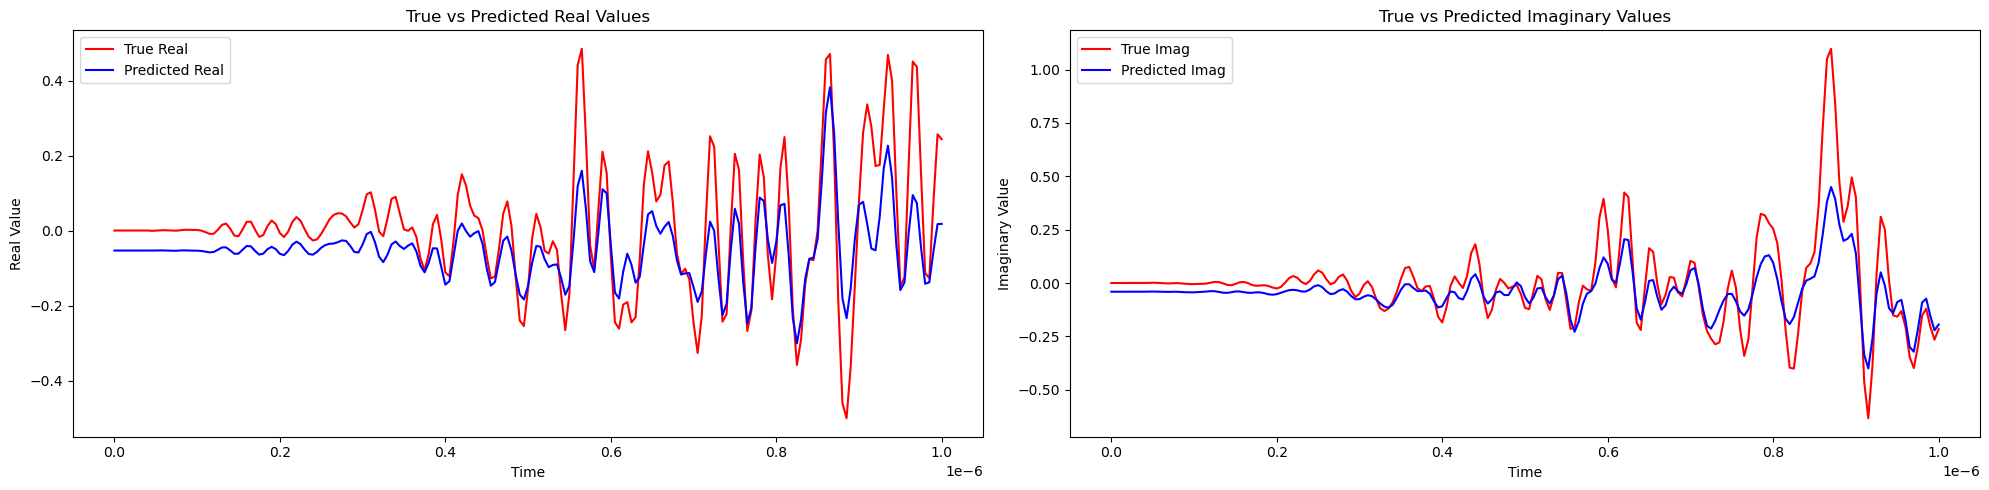

CPU times: user 267 ms, sys: 5.2 ms, total: 272 ms
Wall time: 270 ms


In [21]:
%%time
NODE_model.plot_predictions(time_start=0, time_end=0.1e-5)

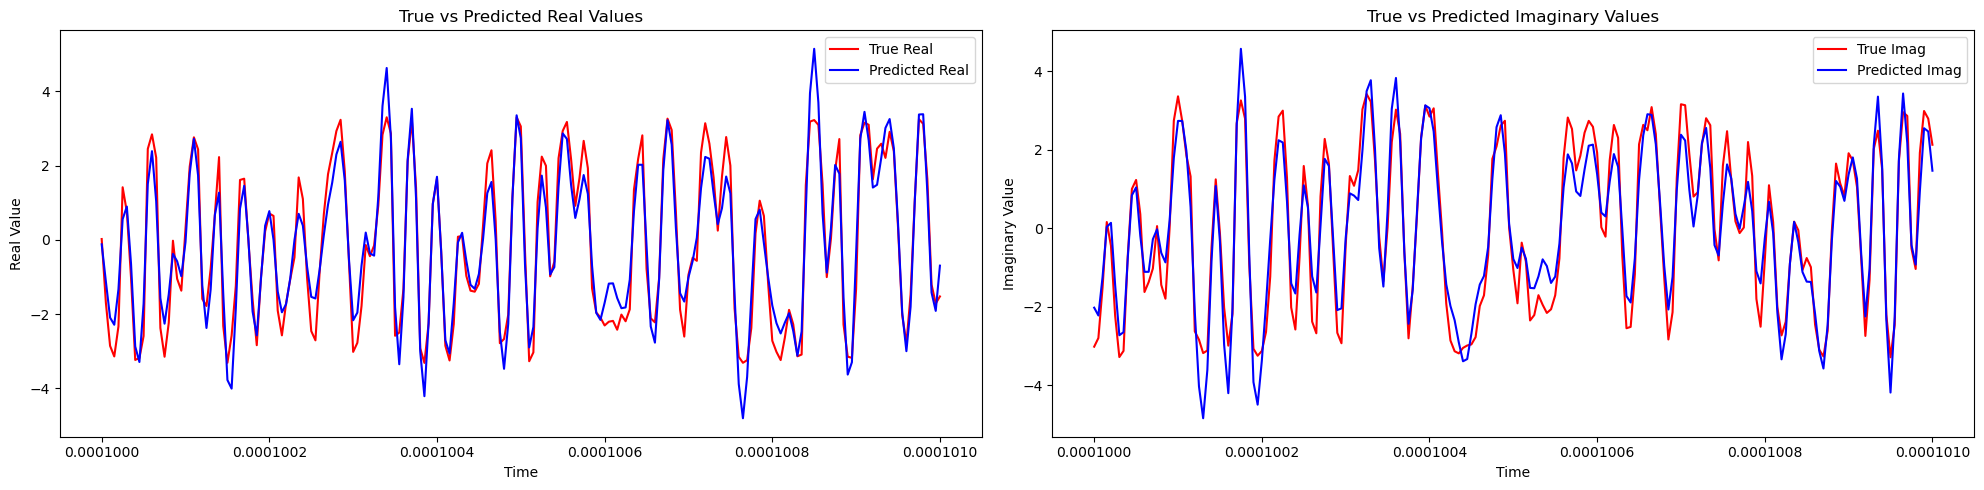

CPU times: user 263 ms, sys: 8.21 ms, total: 272 ms
Wall time: 269 ms


In [22]:
%%time
NODE_model.plot_predictions(time_start=1e-4, time_end=1.01e-4)

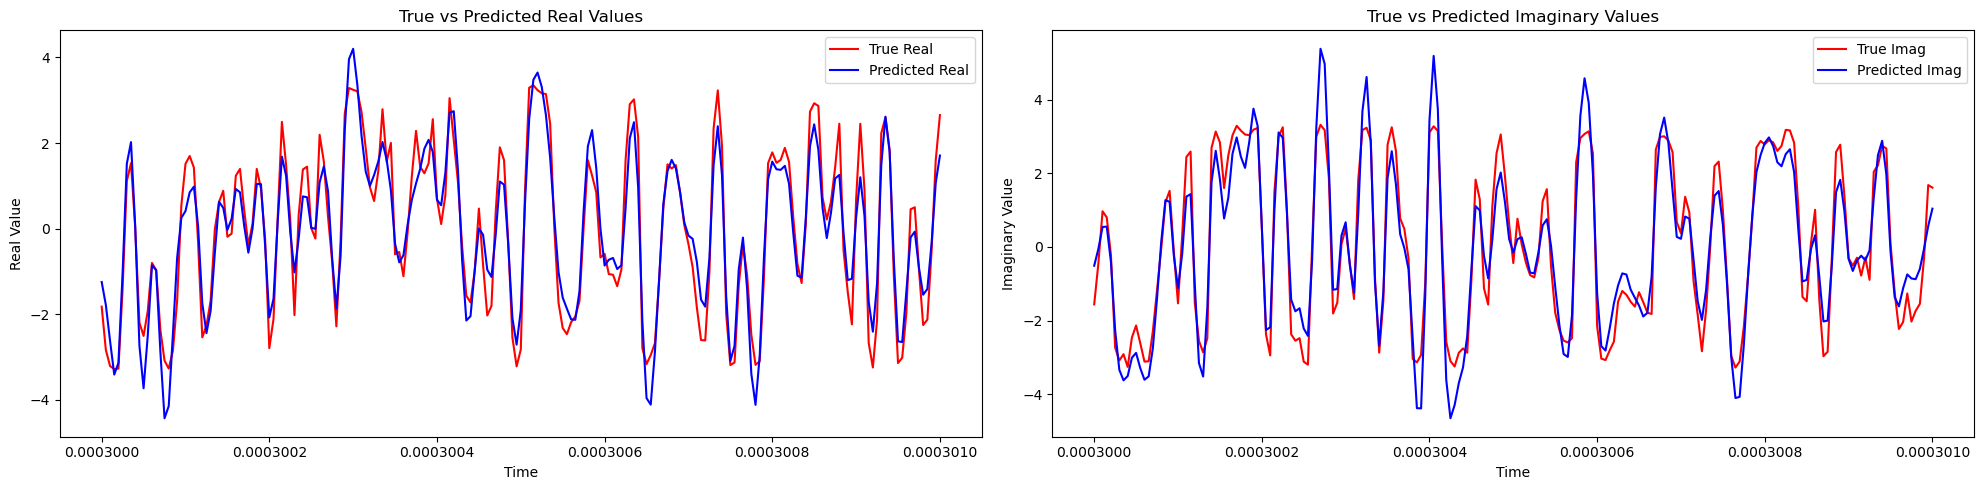

CPU times: user 255 ms, sys: 4.98 ms, total: 260 ms
Wall time: 258 ms


In [23]:
%%time
NODE_model.plot_predictions(time_start=3e-4, time_end=3.01e-4)

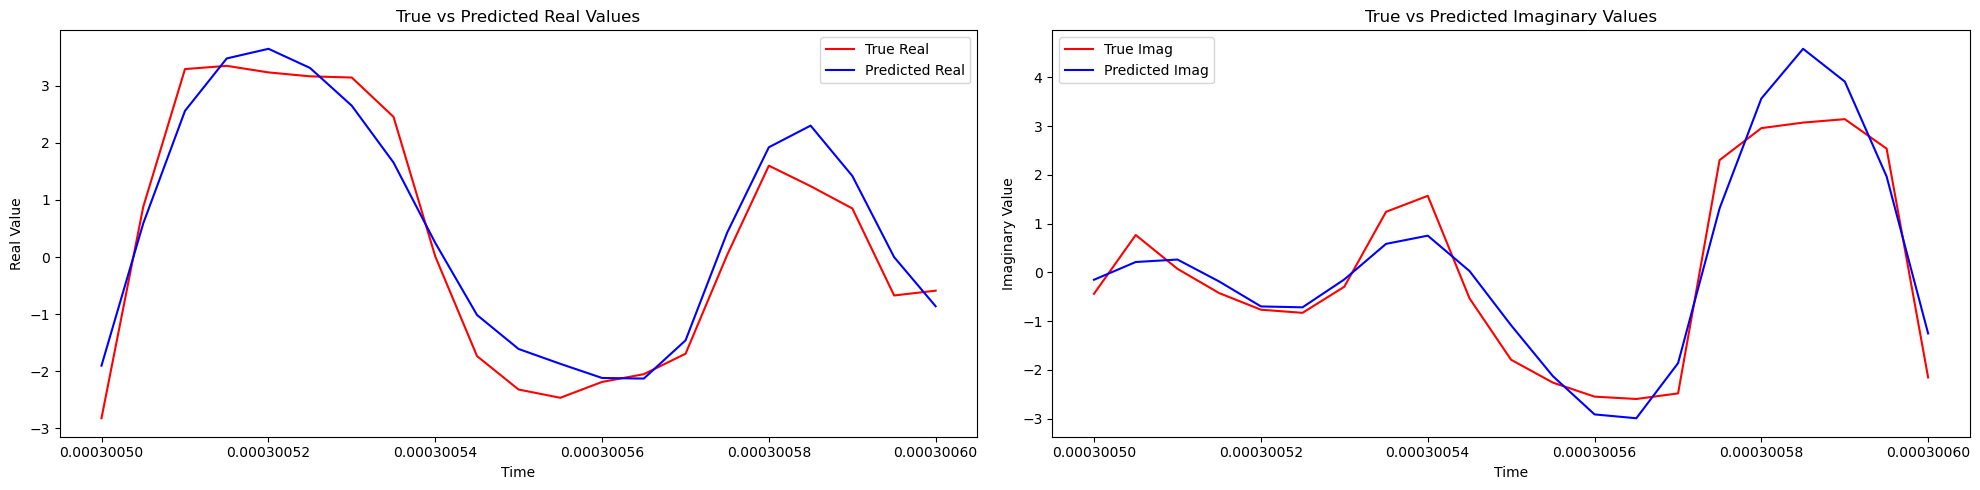

CPU times: user 318 ms, sys: 5.92 ms, total: 324 ms
Wall time: 321 ms


In [24]:
%%time
NODE_model.plot_predictions(time_start=3.005e-4, time_end=3.006e-4)